# Прогнозирование стоимости автомобиля по характеристикам

## Попытки парсинга
После 3 дней неудачных попыток парсинга с auto.ru, на вебинаре сказали, что на эту часть работы сейчас лучше не тратить время, а взять готовый датасет.

In [269]:
import pandas as pd
import numpy as np
import json
import statistics as st
import math
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings("ignore")

### Функции

In [2]:
# Функция, которая ищет количество пересечений уникальных значений двух признаков
def intersection_count(col1,col2):   
    col1_set = set(col1.astype(str).unique())
    col2_set = set(col2.astype(str).unique())
    intersection = col1_set.intersection(col2_set)
    print('Длина первого списка:', len(col1_set), 
          '\nДлина второго списка:', len(col2_set), 
          '\nКоличество пересечений:', len(intersection))
    
    
# Функция извлекает список комплектации из тестовой выборки и заполняет пропуски пустыми списками []
def get_options_dict(value):
    s = str(value)
    if s =='nan':
        return [] # если значение пропущено, возвращаем пустой список
    return json.loads(value)['available_options']


# Функция заполняет пропуски пустыми списками [], или возвращяет значение ячейки
def get_options_list(value):
    s = str(value)
    if s =='nan':
        return []
    return eval(value)


# Функция для создания dummie-переменных для опций
def dummie_options(df, option_list):
    for option in option_list:
        df['OPTION_' + option] = df.complectation_dict.map(lambda x: int(option in x))


# Функция удаления единиц измерения объема двигателя и мощности и замены пропущенных значений на np.nan
def measure_remove(value):
    value = str(value).split(' ')[0]
    if value == 'nan' or value =='' or value == 'undefined':
        return np.nan
    return float(value)


# Функция заполнения пропущенных значений в df на наиболее часто встречающимся значением
def fill_na_mode(df, column):
    mode = st.mode(df[column])
    df[column] = df[column].fillna(mode)
    
    
# Функция замены длительности владения на количество месяцев
def num_of_months(row):
    if pd.notnull(row) and row != 'no_data':
        list_ownership = row.split()  # разделяем строку на список из месяца и лет
        if len(list_ownership) == 2:  # если содержится информация только про годы
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])  # переводим год в месяцы
        return int(list_ownership[0])*12 + int(list_ownership[3])

## Данные

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130201 entries, 0 to 130200
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              129986 non-null  object 
 1   brand                 129988 non-null  object 
 2   car_url               129969 non-null  object 
 3   color                 129988 non-null  object 
 4   complectation_dict    105267 non-null  object 
 5   description           129988 non-null  object 
 6   engineDisplacement    129988 non-null  object 
 7   enginePower           129988 non-null  object 
 8   equipment_dict        129969 non-null  object 
 9   fuelType              129986 non-null  object 
 10  image                 130065 non-null  object 
 11  mileage               103034 non-null  float64
 12  modelDate             129986 non-null  float64
 13  model_info            0 non-null       float64
 14  model_name            103034 non-null  object 
 15  

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [6]:
# Выводим разницу в столбцах между тренировочной и тестовой выборками
list(set(train_df.columns).difference(test_df.columns))

['region', 'price', 'date_added', 'views']

In [7]:
# Убираем колонки, которых нет в тестовой выборке и которые не являются целевой переменной
train_df = train_df.drop(columns = ['views', 'region', 'date_added'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130201 entries, 0 to 130200
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              129986 non-null  object 
 1   brand                 129988 non-null  object 
 2   car_url               129969 non-null  object 
 3   color                 129988 non-null  object 
 4   complectation_dict    105267 non-null  object 
 5   description           129988 non-null  object 
 6   engineDisplacement    129988 non-null  object 
 7   enginePower           129988 non-null  object 
 8   equipment_dict        129969 non-null  object 
 9   fuelType              129986 non-null  object 
 10  image                 130065 non-null  object 
 11  mileage               103034 non-null  float64
 12  modelDate             129986 non-null  float64
 13  model_info            0 non-null       float64
 14  model_name            103034 non-null  object 
 15  

## Пропуски в данных

In [8]:
# Выводим сумму пропущенных значений в каждом из столбцов массива train
train_df.isnull().sum()

bodyType                   215
brand                      213
car_url                    232
color                      213
complectation_dict       24934
description                213
engineDisplacement         213
enginePower                213
equipment_dict             232
fuelType                   215
image                      136
mileage                  27167
modelDate                  215
model_info              130201
model_name               27167
name                        48
numberOfDoors              214
parsing_unixtime            47
priceCurrency               48
productionDate             213
sell_id                    232
super_gen                   66
vehicleConfiguration       214
vehicleTransmission        215
vendor                  130201
Владельцы                27167
Владение                115915
ПТС                      27167
Привод                   27169
Руль                     27168
Состояние                27169
Таможня                  27171
price   

In [9]:
# Выводим сумму пропущенных значений в каждом из столбцов массива test
test_df.isnull().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

## bodyType

In [10]:
train_df['bodyType'].value_counts()

внедорожник 5 дв.          75068
седан                      31879
лифтбек                     6396
минивэн                     3820
хэтчбек 5 дв.               3708
купе                        2706
универсал 5 дв.             1801
пикап двойная кабина        1512
компактвэн                  1476
хэтчбек 3 дв.                704
фургон                       565
внедорожник 3 дв.             99
кабриолет                     85
купе-хардтоп                  64
родстер                       49
микровэн                      30
пикап полуторная кабина        9
пикап одинарная кабина         9
седан-хардтоп                  3
внедорожник открытый           2
лимузин                        1
Name: bodyType, dtype: int64

In [11]:
test_df['bodyType'].value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [12]:
# Заполняем пропуски bodyType в обучающей выборке
train_df['bodyType'] = train_df['bodyType'].fillna(value=('bodyType_не_заполнен'))
train_df[train_df['bodyType'] == 'bodyType_не_заполнен']['bodyType'].value_counts()

bodyType_не_заполнен    215
Name: bodyType, dtype: int64

## brand

In [13]:
train_df['brand'].value_counts()

TOYOTA        20117
VOLKSWAGEN    18005
MERCEDES      17478
NISSAN        16534
BMW           15158
MITSUBISHI    10355
AUDI          10252
SKODA          8545
HONDA          4626
LEXUS          3842
VOLVO          3521
INFINITI       1555
Name: brand, dtype: int64

In [14]:
test_df['brand'].value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

In [15]:
# Заполняем проски brand в обучающей выборке
train_df['brand'] = train_df['brand'].fillna(value=('brand_не_заполнен'))
train_df[train_df['brand'] == 'brand_не_заполнен']['brand'].value_counts()

brand_не_заполнен    213
Name: brand, dtype: int64

In [16]:
train_df.shape

(130201, 33)

## car_url

In [17]:
train_df['car_url'].value_counts()

https://auto.ru/cars/new/group/toyota/land_cruiser_prado/22495145/22496061/1104717062-6ae14d83/    428
https://auto.ru/cars/new/group/toyota/rav_4/21678460/21678548/1105041061-9333c262/                 428
https://auto.ru/cars/new/group/toyota/rav_4/21678504/22537343/1104963137-e0e9d5dc/                 428
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105222495-22d7ca53/                            427
https://auto.ru/cars/new/group/toyota/camry/22813335/22813675/1103971886-d3b55172/                 427
                                                                                                  ... 
https://auto.ru/cars/used/sale/volkswagen/polo/1104927262-fc8fcdd5/                                  1
https://auto.ru/cars/used/sale/mercedes/e_klasse_amg/1105393104-b51e736e/                            1
https://auto.ru/cars/new/group/audi/a3/22848424/22870114/1104183919-6316523c/                        1
https://auto.ru/cars/used/sale/bmw/6er/1104768395-2913d448/              

In [18]:
# Выводим размерность обучающей выборки до удаления дублей
print(train_df.shape)

(130201, 33)


In [19]:
# Определяем параметр, благодаря которому в поле car_url присутствуют дубли
car_url_row = train_df[train_df.car_url == 'https://auto.ru/cars/new/group/toyota/land_cruiser_prado/22495145/22496061/1104717062-6ae14d83/']
for col in car_url_row.columns:
    print(col,car_url_row[col].nunique())

bodyType 1
brand 1
car_url 1
color 1
complectation_dict 1
description 2
engineDisplacement 1
enginePower 1
equipment_dict 4
fuelType 1
image 4
mileage 0
modelDate 1
model_info 0
model_name 0
name 1
numberOfDoors 1
parsing_unixtime 428
priceCurrency 1
productionDate 1
sell_id 1
super_gen 6
vehicleConfiguration 1
vehicleTransmission 1
vendor 0
Владельцы 0
Владение 0
ПТС 0
Привод 0
Руль 0
Состояние 0
Таможня 0
price 2


In [20]:
# Смотрим на состав данных, которые доступны по дублирующейся ссылке
train_df[train_df.car_url == 'https://auto.ru/cars/new/group/toyota/land_cruiser_prado/22495145/22496061/1104717062-6ae14d83/']

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
77739,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
81447,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
81485,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
81523,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
81561,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97787,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
97825,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
97863,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0
97901,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/land_cru...,чёрный,"['cruise-control', 'eco-leather', 'e-adjustmen...",Тойота Центр Брянск заботится о вас В дилерско...,4.0 LTR,249 N12,"{'cruise-control': True, 'asr': True, 'esp': T...",бензин,...,автоматическая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6003000.0


In [21]:
train_df[train_df.car_url == 'https://auto.ru/cars/new/group/toyota/rav_4/21678460/21678548/1105041061-9333c262/']

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
77727,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81437,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81475,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81513,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81551,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97778,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97816,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97853,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97892,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/new/group/toyota/rav_4/21...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",ГК Автомир один из самых крупных автомобильных...,2.0 LTR,149 N12,"{'audiosystem-cd': True, 'airbag-side': True, ...",бензин,...,вариатор,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Вывод: данные по одинаковым ссылка дублируются. Можно все дубли удалить, кроме последнего по времени парсинга.

In [22]:
# Заменяем значения car_url на ссылку последнюю по времени парсинга
train_df = train_df.sort_values('parsing_unixtime').groupby('car_url').tail(1).reset_index(drop=True)

# Проверяем, что каждая ссылка теперь встречается только один раз в обучающей выборке
train_df['car_url'].value_counts(ascending=False)[:5]

https://auto.ru/cars/used/sale/nissan/note/1104874435-358e016d/                               1
https://auto.ru/cars/used/sale/toyota/camry/1105402586-f9616a4c/                              1
https://auto.ru/cars/new/group/volkswagen/caravelle/21793483/21794055/1104837939-a4713529/    1
https://auto.ru/cars/used/sale/lexus/nx/1105099087-5af3acf8/                                  1
https://auto.ru/cars/used/sale/skoda/octavia/1105010229-5b15cdca/                             1
Name: car_url, dtype: int64

In [23]:
# Выявляем пропуски в оставшихся значениях
train_df[train_df['car_url'].isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
40721,bodyType_не_заполнен,brand_не_заполнен,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Удаляем сроку без информации
print(train_df.shape)
train_df = train_df.drop(labels=40721)
print(train_df.shape)

(40722, 33)
(40721, 33)


In [25]:
# Проверяем, что строк с пропущенной ссылкой не осталось
train_df[train_df['car_url'].isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price


## color

In [26]:
train_df['color'].value_counts()

чёрный         11695
белый           9604
серый           5520
серебристый     3728
синий           3606
коричневый      1861
красный         1814
зелёный          832
бежевый          786
голубой          398
золотистый       194
фиолетовый       190
пурпурный        185
оранжевый        159
жёлтый           134
розовый           15
Name: color, dtype: int64

In [27]:
test_df['color'].value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

In [28]:
# Смотрим на количество пропусков
train_df.isnull().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      10890
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict              0
fuelType                    2
image                      66
mileage                  7564
modelDate                   2
model_info              40721
model_name               7564
name                        0
numberOfDoors               1
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        1
vehicleTransmission         2
vendor                  40721
Владельцы                7564
Владение                34065
ПТС                      7564
Привод                   7566
Руль                     7564
Состояние                7566
Таможня                  7567
price                    4204
dtype: int

## complectation_dict

In [29]:
train_df['complectation_dict'].value_counts()[:6]

['airbag-passenger', 'lock', 'glonass', 'computer', 'seat-transformation', 'fabric-seats', 'steel-wheels', 'abs', 'usb', 'audiopreparation', 'spare-wheel', 'ashtray-and-cigarette-lighter', 'servo', 'electro-window-back', 'driver-seat-updown', 'condition', 'airbag-driver', 'isofix', 'aux', 'electro-window-front', 'migration-flag', 'bluetooth', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'third-rear-headrest']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [30]:
test_df['complectation_dict'].value_counts()[:6]

{"id":"4562904","name":"Elegance","available_options":["cruise-control","multi-wheel","airbag-passenger","lock","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","audiopreparation","electro-window-back","condition","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","alarm","ptf","rain-sensor","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [31]:
# Заполняем столбец complectation_dict тестовой выборки с использованием функции get_options_dict
test_df.complectation_dict = test_df.complectation_dict.map(get_options_dict)

In [32]:
# Проверяем результаты работы функции
test_df['complectation_dict'].value_counts()[:6]

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     28268
[cruise-control, xenon, airbag-passenger, lock, electro-mirrors, mirrors-heat, leather, computer, seat-transformation, wheel-power, airbag-side, abs, climate-control-1, esp, audiopreparation, electro-window-back, hatch, condition, music-super, airbag-driver, electro-window-front, passenger-seat-ele

In [33]:
# Заполняем столбец complectation_dict обучающей выборки с использованием функции get_options_dict
train_df.complectation_dict = train_df.complectation_dict.map(get_options_list)

In [34]:
# Проверяем результаты работы функции
train_df['complectation_dict'].value_counts()[:6]

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [35]:
# Считаем количество пересечений в обучающей и тестовой выборке по признаку complectation_dict
intersection_count(train_df.complectation_dict, test_df.complectation_dict) 

Длина первого списка: 2349 
Длина второго списка: 1500 
Количество пересечений: 228


In [36]:
# Создаем список опций для 30 наиболее часто встречающихся опций
options_list_full = list(train_df.complectation_dict.values) + list(test_df.complectation_dict.values)
options_list = []

for option in options_list_full:
    options_list += option

options_array = pd.Series(options_list).value_counts().head(30).index.values
options_array

array(['airbag-driver', 'abs', 'lock', 'immo', 'electro-window-front',
       'airbag-passenger', 'wheel-configuration1', 'computer',
       'electro-mirrors', 'mirrors-heat', 'wheel-configuration2',
       'electro-window-back', 'front-seats-heat', 'esp', 'airbag-side',
       'isofix', 'seat-transformation', 'audiopreparation',
       'audiosystem-cd', 'wheel-leather', 'multi-wheel', 'airbag-curtain',
       'third-rear-headrest', 'usb', 'front-centre-armrest', 'ptf',
       '12v-socket', 'cruise-control', 'rain-sensor', 'bluetooth'],
      dtype=object)

In [37]:
# Создаем dummie-признаки для опций комплектации
dummie_options(train_df, options_array)
dummie_options(test_df, options_array)
train_df.head(10)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,OPTION_multi-wheel,OPTION_airbag-curtain,OPTION_third-rear-headrest,OPTION_usb,OPTION_front-centre-armrest,OPTION_ptf,OPTION_12v-socket,OPTION_cruise-control,OPTION_rain-sensor,OPTION_bluetooth
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"[cruise-control, multi-wheel, xenon, heated-wa...",Автомобиль приобретался у официального дилера ...,1.8 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,1,1,0,1,1,1,1,1,1,1
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"[cruise-control, multi-wheel, heated-wash-syst...",Группа компаний Элан Моторс официальный дилер ...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,1,1,1,1,1,1,1,1,1,1
2,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/yeti/1105...,серый,"[cruise-control, multi-wheel, heated-wash-syst...",Продаётся автомобиль в отличном состоянии Влож...,1.8 LTR,152 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,1,1,1,1,1,1,1,1,1,1
3,компактвэн,SKODA,https://auto.ru/cars/used/sale/skoda/roomster/...,белый,"[heated-wash-system, airbag-passenger, lock, e...",Срочно Автомобиль в отличном техническом состо...,1.6 LTR,105 N12,"{'cruise-control': True, 'tinted-glass': True,...",бензин,...,0,0,0,0,0,0,0,0,0,0
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,[],В продаже Skoda Rapid в идеальном состоянии ОД...,1.2 LTR,90 N12,"{'computer': True, 'condition': True, 'front-s...",бензин,...,0,0,0,0,0,0,0,0,0,0
5,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/yeti/1104...,чёрный,"[heated-wash-system, airbag-passenger, roof-ra...",При покупке данного автомобиля в кредит вы пол...,1.2 LTR,105 N12,"{'engine-proof': True, 'asr': True, 'airbag-dr...",бензин,...,0,0,0,0,0,0,1,0,0,0
6,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"[cruise-control, multi-wheel, xenon, heated-wa...",Только один день автомобили с пробегом с выгод...,1.8 LTR,180 N12,"{'cruise-control': True, 'tinted-glass': True,...",бензин,...,1,1,1,1,1,1,1,1,1,1
7,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"[cruise-control, multi-wheel, heated-wash-syst...",ВНИМАНИЕ ДИЛЕРСКИЙ ЦЕНТР НАХОДИТСЯ ПО АДРЕСУ п...,1.6 LTR,90 N12,"{'cruise-control': True, 'esp': True, 'usb': T...",бензин,...,1,1,1,1,1,1,1,1,1,1
8,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"[cruise-control, multi-wheel, heated-wash-syst...",ПОМОЩНИКИ И ПРОЧИЕ ЖЕЛАЮЩИЕ ЗАРАБОТАТЬ ЛУЧШЕ Н...,1.4 LTR,150 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,1,1,1,1,1,1,1,1,1,1
9,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,красный,"[cruise-control, multi-wheel, heated-wash-syst...",Ищете надежный автомобиль с пробегом Тогда Вам...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,1,1,1,1,1,1,1,1,1,1


## engineDisplacement

In [38]:
train_df.engineDisplacement.value_counts()

2.0 LTR    12344
1.6 LTR     5317
3.0 LTR     3759
2.5 LTR     2530
1.4 LTR     2378
2.4 LTR     2201
3.5 LTR     2054
1.8 LTR     2021
1.5 LTR     1203
1.3 LTR      536
1.2 LTR      489
4.0 LTR      484
2.9 LTR      410
5.7 LTR      401
4.5 LTR      398
2.8 LTR      362
2.7 LTR      308
5.6 LTR      292
3.7 LTR      288
4.7 LTR      281
4.6 LTR      280
4.4 LTR      258
2.1 LTR      248
2.3 LTR      211
3.2 LTR      206
5.5 LTR      194
2.2 LTR      153
0.7 LTR      138
3.6 LTR      137
5.0 LTR      100
1.9 LTR       96
1.7 LTR       91
4.2 LTR       90
3.3 LTR       87
 LTR          80
4.3 LTR       42
1.0 LTR       39
3.4 LTR       37
3.8 LTR       36
3.1 LTR       33
2.6 LTR       20
6.0 LTR       18
4.8 LTR       12
5.4 LTR       12
6.2 LTR       11
4.1 LTR        9
6.6 LTR        9
5.2 LTR        7
5.9 LTR        6
4.9 LTR        2
1.1 LTR        2
5.8 LTR        1
Name: engineDisplacement, dtype: int64

In [39]:
test_df.engineDisplacement.value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
3.8 LTR      57
1.0 LTR      57
 LTR         55
2.6 LTR      55
0.7 LTR      53
6.0 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.9 LTR      12
5.2 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

In [40]:
# Обрабатываем поле в обучающей и тестовой выборке при помощи фукции measure_remove
test_df.engineDisplacement = test_df.engineDisplacement.map(measure_remove)
train_df.engineDisplacement = train_df.engineDisplacement.map(measure_remove)

In [41]:
# Проверяем результаты работы функции
train_df.engineDisplacement.unique()

array([1.8, 1.6, 1.2, 1.4, 2. , 3.6, 1.5, 1.9, 1.3, 2.8, 3. , 2.7, 4. ,
       2.4, 2.9, 4.2, 2.5, 3.2, 4.1, 3.1, 3.7, 2.3, 2.2, 2.6, nan, 5.9,
       5.2, 5. , 2.1, 6. , 3.5, 0.7, 1.7, 4.4, 5.6, 4.8, 6.6, 4.6, 4.9,
       3.4, 5.4, 1. , 3.3, 3.8, 4.5, 5.5, 4.7, 6.2, 5.8, 4.3, 5.7, 1.1])

In [42]:
test_df.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, nan, 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7])

In [43]:
# Заменяем пропуски на наиболее часто встречающиеся значения
fill_na_mode(train_df, 'engineDisplacement')
fill_na_mode(test_df, 'engineDisplacement')

# Проверяем результаты замены пропусков
print(train_df.engineDisplacement.unique())
print('Пропуски engineDisplacement обучающей выборки:', train_df.engineDisplacement.isnull().sum())
print(test_df.engineDisplacement.unique())
print('Пропуски engineDisplacement тестовой выборки:', test_df.engineDisplacement.isnull().sum())

[1.8 1.6 1.2 1.4 2.  3.6 1.5 1.9 1.3 2.8 3.  2.7 4.  2.4 2.9 4.2 2.5 3.2
 4.1 3.1 3.7 2.3 2.2 2.6 5.9 5.2 5.  2.1 6.  3.5 0.7 1.7 4.4 5.6 4.8 6.6
 4.6 4.9 3.4 5.4 1.  3.3 3.8 4.5 5.5 4.7 6.2 5.8 4.3 5.7 1.1]
Пропуски engineDisplacement обучающей выборки: 0
[1.2 1.6 1.8 2.  1.4 1.3 1.  3.6 1.5 1.9 2.8 1.1 2.5 4.2 3.  4.  5.9 2.7
 3.1 2.4 5.2 3.2 4.1 6.3 2.3 6.  2.2 3.7 2.9 5.  3.3 2.1 2.6 3.5 1.7 0.7
 4.4 4.8 5.4 6.6 4.9 3.8 3.4 3.9 4.6 5.6 4.5 5.5 6.2 4.7 4.3 5.8 5.3 5.7]
Пропуски engineDisplacement тестовой выборки: 0


## enginePower

In [44]:
# Смотрим на перечень значений поля в обучающей выборке
train_df.enginePower.unique()

array(['180 N12', '110 N12', '152 N12', '105 N12', '90 N12', '150 N12',
       '70 N12', '80 N12', '102 N12', '122 N12', '140 N12', '125 N12',
       '86 N12', '75 N12', '68 N12', '115 N12', '260 N12', '280 N12',
       '64 N12', '220 N12', '143 N12', '100 N12', '58 N12', '200 N12',
       '60 N12', '160 N12', '170 N12', '120 N12', '54 N12', '190 N12',
       '69 N12', '79 N12', '101 N12', '193 N12', '184 N12', '53 N12',
       '249 N12', '225 N12', '245 N12', '204 N12', '340 N12', '333 N12',
       '211 N12', '300 N12', '460 N12', '239 N12', '310 N12', '520 N12',
       '165 N12', '272 N12', '422 N12', '130 N12', '450 N12', '350 N12',
       '230 N12', '163 N12', '233 N12', '177 N12', '238 N12', '265 N12',
       '290 N12', '435 N12', '344 N12', '255 N12', '372 N12', '133 N12',
       '136 N12', '250 N12', '270 N12', '252 N12', '600 N12', '605 N12',
       '367 N12', '420 N12', '354 N12', '408 N12', '88 N12', '71 N12',
       '500 N12', '271 N12', '400 N12', '218 N12', '210 N12', '335

In [45]:
# Смотрим на перечень значений поля в тестовой выборке
test_df.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [46]:
# Убираем единицы измерения в обучающей и тестовой выборке
test_df.enginePower = test_df.enginePower.map(measure_remove)
train_df.enginePower = train_df.enginePower.map(measure_remove)

In [47]:
# Проверяем результаты работы функции
print(train_df.enginePower.unique())
print(test_df.enginePower.unique())

[180. 110. 152. 105.  90. 150.  70.  80. 102. 122. 140. 125.  86.  75.
  68. 115. 260. 280.  64. 220. 143. 100.  58. 200.  60. 160. 170. 120.
  54. 190.  69.  79. 101. 193. 184.  53. 249. 225. 245. 204. 340. 333.
 211. 300. 460. 239. 310. 520. 165. 272. 422. 130. 450. 350. 230. 163.
 233. 177. 238. 265. 290. 435. 344. 255. 372. 133. 136. 250. 270. 252.
 600. 605. 367. 420. 354. 408.  88.  71. 500. 271. 400. 218. 210. 335.
 571. 560. 174. 112. 144. 137. 646. 113. 610. 580. 525. 550. 231. 380.
 320. 313. 360. 256.  93. 145. 201. 186. 166. 156. 147. 118. 155.  83.
 205. 132. 154.  98. 158. 128. 257. 243. 162. 192.  91. 295. 103. 142.
  95. 194. 275. 116. 173. 281.  66. 135.  94. 188. 185. 109. 131.  99.
  52. 182.  85. 141. 212.  42. 124. 248. 240. 247.  50. 215.  46. 175.
 314.  76. 237. 197.  67.  44. 114.  82. 176. 148.  nan 106.  92.  78.
 181. 235. 286. 203. 254. 315. 304. 126. 117. 407.  87. 306. 213. 285.
  72. 111. 258. 575. 326. 530. 381. 370. 555. 355. 462. 625. 431. 609.
 129. 

In [48]:
# Смотрим на количество пропусков
print(train_df.enginePower.isnull().sum())
print(test_df.enginePower.isnull().sum())

2
0


In [49]:
# Заменяем пропуски на наиболее часто встречающиеся значения
fill_na_mode(train_df, 'enginePower')

# Проверяем наличие пропусков
print(train_df.enginePower.isnull().sum())

0


## equipment_dict

In [50]:
train_df.equipment_dict.unique()

array(["{'cruise-control': True, 'asr': True, 'tinted-glass': True, 'esp': True, 'adaptive-light': True, 'usb': True, 'multi-wheel': True, 'xenon': True, 'audiosystem-tv': True, 'heated-wash-system': True, 'ashtray-and-cigarette-lighter': True, 'airbag-passenger': True, 'front-centre-armrest': True, 'lock': True, 'door-sill-panel': True, 'servo': True, 'electro-mirrors': True, 'drl': True, 'electro-window-back': True, 'feedback-alarm': True, 'mirrors-heat': True, 'volume-sensor': True, '17-inch-wheels': True, 'dark-interior': True, 'park-assist-f': True, 'combo-interior': True, 'rear-seats-heat': True, 'cooling-box': True, 'seat-memory': True, 'music-super': True, 'park-assist-r': True, 'engine-proof': True, 'start-stop-function': True, 'airbag-driver': True, 'isofix': True, 'aux': True, 'drive-mode-sys': True, 'electro-window-front': True, 'light-sensor': True, 'hcc': True, 'automatic-lighting-control': True, 'airbag-curtain': True, 'passenger-seat-updown': True, 'computer': True, 'se

In [51]:
test_df.equipment_dict.unique()

array(['{"engine-proof":true,"tinted-glass":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"high-beam-assist":true,"seat-transformation":true,"isofix-front":true,"wheel-power":true,"alarm":true,"lock":true,"door-sill-panel":true,"fabric-seats":true,"electro-mirrors":true,"airbag-rear-side":true,"electro-window-back":true,"steel-wheels":true,"ptf":true,"16-inch-wheels":true,"rain-sensor":true,"airbag-side":true,"audiosystem-cd":true,"dark-interior":true,"cooling-box":true,"condition":true,"abs":true,"power-child-locks-rear-doors":true,"front-seats-heat":true,"wheel-configuration2":true,"wheel-configuration1":true,"12v-socket":true,"park-assist-r":true}',
       '{"cruise-control":true,"asr":true,"esp":true,"airbag-driver":true,"isofix":true,"usb":true,"light-sensor":true,"airbag-passenger":true,"computer":true,"wheel-power":true,"alarm":true,"lock":true,"fabric-seats":true,"elect

Данные в поле дублируют информацию из **complectation_dict**, не будем его учитывать в дальнейшем.

## fuelType

In [52]:
train_df.fuelType.unique()

array(['бензин', 'дизель', 'электро', 'гибрид', nan, 'газ'], dtype=object)

In [53]:
test_df.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [54]:
# Сравниваем значения показателя в обучающей и тестовой выборках
a = set(train_df.fuelType.unique())
b = set(test_df.fuelType.unique())

print(len(a))
print(len(b))
print(len(a.intersection(b)))

6
5
5


In [55]:
# Смотрим на количество пропущенных значений
train_df.fuelType.isnull().sum()

2

In [56]:
# Заменяем пропуски на наиболее часто встречающиеся значения
fill_na_mode(train_df, 'fuelType')

# Проверяем наличие пропусков
print(train_df.fuelType.isnull().sum())
train_df.fuelType.unique()

0


array(['бензин', 'дизель', 'электро', 'гибрид', 'газ'], dtype=object)

## mileage

In [57]:
print(train_df.mileage.dtype)
train_df.mileage.value_counts()

float64


200000.0    319
250000.0    282
300000.0    275
150000.0    238
180000.0    220
           ... 
520000.0      1
211504.0      1
94844.0       1
58309.0       1
154255.0      1
Name: mileage, Length: 15181, dtype: int64

In [58]:
print(test_df.mileage.dtype)
test_df.mileage.value_counts()

int64


200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
152129      1
4681        1
461386      1
121424      1
69630       1
Name: mileage, Length: 11268, dtype: int64

In [59]:
# Приводим данные столбца mileage в тестовой выборке к формату float64
test_df.mileage = test_df.mileage.astype('float64')
print(test_df.mileage.dtype)

float64


In [60]:
# Считаем количество пропущенных значений
print(train_df.mileage.isnull().sum())
print(test_df.mileage.isnull().sum())

7564
0


In [61]:
# Смотрим на формат пропусков
train_df[train_df.mileage.isnull() == True].mileage

14      NaN
18      NaN
34      NaN
44      NaN
47      NaN
         ..
40696   NaN
40700   NaN
40708   NaN
40712   NaN
40716   NaN
Name: mileage, Length: 7564, dtype: float64

In [62]:
# Заменяем пропущенные значения у новых автомобилей на 0
train_df.mileage.loc[(train_df.mileage.isna() == True) & (train_df.car_url.str.contains('new') == True)] = 0
train_df.mileage.value_counts()

0.0         7564
200000.0     319
250000.0     282
300000.0     275
150000.0     238
            ... 
76089.0        1
520000.0       1
211504.0       1
94844.0        1
154255.0       1
Name: mileage, Length: 15182, dtype: int64

In [63]:
# Считаем количество пропущенных значений
print(train_df.mileage.isnull().sum())

0


## modelDate

In [64]:
print(train_df.modelDate.dtype)
train_df.modelDate.unique()

float64


array([2013., 2020., 2010., 2012., 2009., 2015., 2019., 2007., 2016.,
       2017., 2008., 2000., 2004., 1999., 2014., 1996., 2006., 1994.,
       1998., 2001., 1989., 1976., 2011., 2018., 1997., 1986., 2005.,
       1990., 1988., 1991., 1982., 1978., 2003., 2002., 1983., 1987.,
       1979., 1984., 1995., 1993., 1985., 1992., 1981.,   nan, 1974.,
       1975., 2021., 1980., 1959., 1958., 1968., 1951., 1938., 1953.])

In [65]:
print(test_df.modelDate.dtype)
test_df.modelDate.unique()

int64


array([2013, 2017, 2008, 2009, 2016, 2012, 2015, 2010, 2006, 2000, 2007,
       1994, 2004, 1999, 2005, 1976, 2001, 1969, 1996, 1998, 1989, 1934,
       2014, 2011, 2018, 1986, 1997, 1990, 2019, 2002, 1991, 1987, 1980,
       1982, 1938, 1988, 2003, 1983, 1978, 1979, 1984, 1992, 1995, 1993,
       1985, 1974, 1966, 1977, 1981, 1972, 1968, 1975, 1949, 1937, 1936,
       1973, 1959, 1958, 2020, 1965, 1971, 1904, 1963, 1955, 1951, 1960],
      dtype=int64)

In [66]:
# Считаем количество пропущенных значений
print(train_df.modelDate.isnull().sum())
print(test_df.modelDate.isnull().sum())

2
0


In [67]:
# Заполняем пропуски в обучающей выборке наиболее часто встречающемися значениями
fill_na_mode(train_df, 'modelDate')

# Проверяем наличие пропусков
print(train_df.modelDate.isnull().sum())
train_df.modelDate.unique()

0


array([2013., 2020., 2010., 2012., 2009., 2015., 2019., 2007., 2016.,
       2017., 2008., 2000., 2004., 1999., 2014., 1996., 2006., 1994.,
       1998., 2001., 1989., 1976., 2011., 2018., 1997., 1986., 2005.,
       1990., 1988., 1991., 1982., 1978., 2003., 2002., 1983., 1987.,
       1979., 1984., 1995., 1993., 1985., 1992., 1981., 1974., 1975.,
       2021., 1980., 1959., 1958., 1968., 1951., 1938., 1953.])

In [68]:
# Типы данных отличаются. Переводим данные в обучающей выборке к int64
train_df.modelDate = train_df.modelDate.astype('int64')
print(train_df.modelDate.dtype)

int64


## model_info

In [69]:
test_df.model_info

0        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
1        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
2        {"code":"SUPERB","name":"Superb","ru_name":"Су...
3        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
4        {"code":"OCTAVIA","name":"Octavia","ru_name":"...
                               ...                        
34681    {"code":"3ER","name":"3 серии","ru_name":"3 се...
34682    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34683    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34684    {"code":"X1","name":"X1","ru_name":"Х1","morph...
34685    {"code":"X5","name":"X5","ru_name":"Х5","morph...
Name: model_info, Length: 34686, dtype: object

Информация в поле дублирует другие столбцы и не заполнена в обучающей выборке. В дальнейшем не использовать ее.

## model_name

In [70]:
print(len(train_df.model_name.unique()))
train_df.model_name.unique()

515


array(['Octavia', 'Rapid', 'Yeti', 'Roomster', 'Superb', 'Fabia',
       'Kodiaq', nan, 'Karoq', 'Felicia', 'Octavia RS', 'Fabia RS',
       'Favorit', '105, 120', 'A7', 'A6', 'A5', 'Q7', 'TT', 'A4', 'Q5',
       'A3', 'Q3', 'A8', 'S8', 'TTS', 'SQ7', 'RS 5', '80', 'Q8',
       'A6 allroad', 'A1', 'A4 allroad', 'S4', '100', '200', 'RS Q3',
       'A2', 'RS 6', 'RS 3', 'SQ5', 'Q3 Sportback', 'TT RS', 'RS 7', 'S6',
       'S5', 'SQ8', 'e-tron', 'R8', 'e-tron Sportback', 'V8',
       'RS e-tron GT', 'Q5 Sportback', '90', 'RS 4', 'S1', 'S7', 'Coupe',
       'S3', 'Orthia', 'Accord', 'Civic', 'CR-V', 'Pilot', 'Freed',
       'Jazz', 'HR-V', 'N-WGN', 'Stepwgn', 'Stream', 'Legend', 'Vezel',
       'Odyssey', 'Capa', 'Integra', 'Fit', 'Shuttle', 'Fit Aria',
       'Insight', 'Saber', 'Prelude', 'Element', 'Airwave', 'Partner',
       'Crosstour', 'Civic Ferio', 'Torneo', 'N-BOX', 'Logo', 'Mobilio',
       'Mobilio Spike', 'Fit Shuttle', 'Crossroad', 'FR-V', 'S660',
       'Domani', 'Ascot', 'In

In [71]:
print(len(test_df.model_name.unique()))
test_df.model_name.unique()

544


array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR', 'Q5', 'R8', 'Q7', 'Q3', 'A4',
       'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6', 'ALLROAD', 'TT', 'S5', 'S8',
       'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3', 'A4_ALLROAD', 'Q8', '100',
       'SQ5', 'S4', 'TT_RS', 'RS4', 'S7', 'RS5', '90', 'COUPE', 'A2',
       'TTS', '920', 'S3', '200', 'V8', 'E_TRON', 'CR_V', 'ACCORD',
       'PILOT', 'CIVIC', 'ODYSSEY', 'STREAM', 'CROSSTOUR', 'ELYSION',
       'ELEMENT', 'RIDGELINE', 'FIT', 'HR_V', 'SHUTTLE', 'FREED',
       'ODYSSEY_NA', 'JAZZ', 'Z', 'CIVIC_FERIO', 'S2000', 'CR_Z',
       'LEGEND', 'STEPWAGON', 'CIVIC_TYPE_R', 'FR_V', 'CR_X', 'PRELUDE',
       'MOBILIO_SPIKE', 'N_BOX', 'ZEST', 'INTEGRA', 'INSPIRE', 'VEZEL',
       'N_WGN', 'ASCOT', 'LOGO', 'ACTY', 'CONCERTO', 'AVANCIER', 'SABER',
       'MOBILIO', 'CROSSROAD', 'INSIGHT', 'TORNEO', 'AIRWAVE', 'DOMANI',
       'RAFA

In [72]:
# Приводим значения в обучающей выборке к формату значений в тестовой выборке
train_df.model_name = train_df.model_name.str.upper()
train_df.model_name[:5]

0     OCTAVIA
1       RAPID
2        YETI
3    ROOMSTER
4       RAPID
Name: model_name, dtype: object

In [73]:
# Считаем количество пропущенных значений
print(train_df.model_name.isnull().sum())
print(test_df.model_name.isnull().sum())

7564
0


In [74]:
# Определяем вид значений-пропусков
train_df[train_df.model_name.isnull()].model_name

14       NaN
18       NaN
34       NaN
44       NaN
47       NaN
        ... 
40696    NaN
40700    NaN
40708    NaN
40712    NaN
40716    NaN
Name: model_name, Length: 7564, dtype: object

In [75]:
# Заменяем пропущенные значения на выдержку из столбца super_gen
for row in train_df.iterrows():
    
    # Если в ячейке пропуск
    if row[1].model_name != row[1].model_name: 
        
        # Находим значение парсингом в super_gen
        s = row[1]['super_gen'].replace('\'', '\"').replace('None', '\"\"')
        d = json.loads(s)['sale-data-attributes']
        
        # Присваиваем ячейке исходного датасета найденное значение
        train_df.loc[row[0], ['model_name']] = d.get('model')
        
        
# Проверяем количество пропусков
train_df.model_name.isnull().sum()

0

In [76]:
# Смотрим на количество пересечений 
intersection_count(train_df.model_name,test_df.model_name)

Длина первого списка: 565 
Длина второго списка: 544 
Количество пересечений: 360


## name

In [77]:
print(len(train_df.name.unique()))
train_df.name.unique()

2253


array(['Skoda Octavia III (A7)', 'Skoda Rapid II',
       'Skoda Yeti I Рестайлинг', ..., 'Mitsubishi Lancer Evolution X',
       'Mitsubishi Outlander PHEV III Рестайлинг 3',
       'Mitsubishi Eclipse Cross I Рестайлинг'], dtype=object)

In [78]:
print(len(test_df.name.unique()))
test_df.name.unique()

2780


array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
       'DSG 1.8 AMT (152 л.с.)', ...,
       'Arctic Trucks AT38 2.8d AT (177 л.с.) 4WD',
       '2.0 MT (151 л.с.) 4WD', '300 3.0 AT (218 л.с.)'], dtype=object)

Данные имеют разную суть. В дальнейшем не использовать.

## numberOfDoors

In [79]:
print(len(train_df.numberOfDoors.unique()))
print(train_df.numberOfDoors.dtype)
train_df.numberOfDoors.unique()

5
float64


array([ 5.,  4.,  2.,  3., nan])

In [80]:
print(len(test_df.numberOfDoors.unique()))
print(test_df.numberOfDoors.dtype)
test_df.numberOfDoors.unique()

5
int64


array([5, 4, 2, 3, 0], dtype=int64)

In [81]:
# В обучающей выборке есть пропуски, посчитаем их количество
train_df.numberOfDoors.isnull().sum()

1

In [82]:
test_df.numberOfDoors.isnull().sum()

0

In [83]:
# Заполним пропуск наиболее часто встречающимся значением
fill_na_mode(train_df, 'numberOfDoors')
train_df.numberOfDoors.isnull().sum()

0

In [84]:
# Приводим данные в обучающей выборке к формату int64
train_df.numberOfDoors = train_df.numberOfDoors.astype('int64')
print(train_df.numberOfDoors.dtype)

int64


## parsing_unixtime

In [85]:
print(len(train_df.parsing_unixtime.unique()))
print(train_df.parsing_unixtime.dtype)
train_df.parsing_unixtime.unique()

40721
float64


array([1.63261348e+09, 1.63261348e+09, 1.63261352e+09, ...,
       1.63304905e+09, 1.63304905e+09, 1.63304906e+09])

In [86]:
print(len(test_df.parsing_unixtime.unique()))
print(test_df.parsing_unixtime.dtype)
test_df.parsing_unixtime.unique()

34686
int64


array([1603226273, 1603226277, 1603226280, ..., 1603707843, 1603707909,
       1603710264], dtype=int64)

Не несет важной информации для предсказаний, не использовать.

## priceCurrency

In [87]:
print(len(train_df.priceCurrency.unique()))
print(train_df.priceCurrency.dtype)
train_df.priceCurrency.unique()

1
object


array(['RUB'], dtype=object)

In [88]:
print(len(test_df.priceCurrency.unique()))
print(test_df.priceCurrency.dtype)
test_df.priceCurrency.unique()

1
object


array(['RUB'], dtype=object)

В атрибуте только одно значение, не использовать.

## productionDate

In [89]:
print(len(train_df.productionDate.unique()))
print(train_df.productionDate.dtype)
train_df.productionDate.unique()

50
float64


array([2015., 2020., 2017., 2012., 2016., 2011., 2021., 2007., 2019.,
       2018., 2009., 2010., 2013., 2014., 2008., 2003., 2000., 2001.,
       2006., 2004., 1999., 1998., 1997., 2005., 2002., 1996., 1992.,
       1984., 1987., 1995., 1990., 1991., 1989., 1994., 1988., 1986.,
       1983., 1993., 1985., 1980., 1982., 1978., 1974., 1979., 1969.,
       1959., 1975., 1976., 1952., 1973.])

In [90]:
print(len(test_df.productionDate.unique()))
print(test_df.productionDate.dtype)
test_df.productionDate.unique()

69
int64


array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948], dtype=int64)

In [91]:
# Проверим наличие пропусков
print(train_df.productionDate.isnull().sum())
print(test_df.productionDate.isnull().sum())

0
0


In [92]:
# Приводим данные в обучающей выборке к формату int64
train_df.productionDate = train_df.productionDate.astype('int64')
print(train_df.productionDate.dtype)

int64


## sell_id

In [93]:
print(len(train_df.sell_id.unique()))
print(train_df.sell_id.dtype)
train_df.sell_id.unique()

40721
float64


array([1.10511072e+09, 1.10481920e+09, 1.10540246e+09, ...,
       1.10539870e+09, 1.10473817e+09, 1.10534366e+09])

In [94]:
print(len(test_df.sell_id.unique()))
print(test_df.sell_id.dtype)
test_df.sell_id.unique()

34686
int64


array([1100575026, 1100549428, 1100658222, ..., 1101364889, 1101362518,
       1101256068], dtype=int64)

Технический параметр, не использовать.

## vehicleConfiguration

In [95]:
print(len(train_df.vehicleConfiguration.unique()))
print(train_df.vehicleConfiguration.dtype)
train_df.vehicleConfiguration.unique()

565
object


array(['LIFTBACK ROBOT 1.8', 'LIFTBACK AUTOMATIC 1.6',
       'ALLROAD_5_DOORS ROBOT 1.8', 'COMPACTVAN MECHANICAL 1.6',
       'LIFTBACK MECHANICAL 1.2', 'ALLROAD_5_DOORS MECHANICAL 1.2',
       'WAGON_5_DOORS ROBOT 1.8', 'LIFTBACK MECHANICAL 1.6',
       'LIFTBACK AUTOMATIC 1.4', 'HATCHBACK_5_DOORS MECHANICAL 1.2',
       'ALLROAD_5_DOORS ROBOT 2.0', 'ALLROAD_5_DOORS AUTOMATIC 1.4',
       'ALLROAD_5_DOORS ROBOT 1.4', 'WAGON_5_DOORS MECHANICAL 1.4',
       'LIFTBACK MECHANICAL 1.4', 'ALLROAD_5_DOORS MECHANICAL 1.6',
       'ALLROAD_5_DOORS ROBOT 1.2', 'LIFTBACK ROBOT 1.4',
       'LIFTBACK ROBOT 2.0', 'LIFTBACK MECHANICAL 1.8',
       'LIFTBACK AUTOMATIC 1.8', 'ALLROAD_5_DOORS MECHANICAL 1.8',
       'WAGON_5_DOORS MECHANICAL 1.6', 'ALLROAD_5_DOORS AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.4', 'WAGON_5_DOORS MECHANICAL 1.8',
       'ALLROAD_5_DOORS MECHANICAL 1.4', 'WAGON_5_DOORS ROBOT 2.0',
       'COMPACTVAN MECHANICAL 1.4', 'WAGON_5_DOORS ROBOT 1.4',
       'HATCHBACK_

In [96]:
print(len(test_df.vehicleConfiguration.unique()))
print(test_df.vehicleConfiguration.dtype)
test_df.vehicleConfiguration.unique()

634
object


array(['LIFTBACK ROBOT 1.2', 'LIFTBACK MECHANICAL 1.6',
       'LIFTBACK ROBOT 1.8', 'LIFTBACK AUTOMATIC 1.6',
       'LIFTBACK AUTOMATIC 1.8', 'LIFTBACK ROBOT 2.0',
       'ALLROAD_5_DOORS ROBOT 1.8', 'ALLROAD_5_DOORS MECHANICAL 1.4',
       'ALLROAD_5_DOORS MECHANICAL 1.8', 'LIFTBACK ROBOT 1.4',
       'ALLROAD_5_DOORS ROBOT 1.4', 'ALLROAD_5_DOORS ROBOT 2.0',
       'ALLROAD_5_DOORS MECHANICAL 1.2', 'LIFTBACK MECHANICAL 1.4',
       'HATCHBACK_5_DOORS AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.2', 'ALLROAD_5_DOORS ROBOT 1.2',
       'SEDAN AUTOMATIC 1.8', 'COMPACTVAN AUTOMATIC 1.6',
       'WAGON_5_DOORS ROBOT 2.0', 'LIFTBACK MECHANICAL 1.8',
       'ALLROAD_5_DOORS AUTOMATIC 1.6', 'HATCHBACK_5_DOORS ROBOT 1.2',
       'WAGON_5_DOORS ROBOT 1.8', 'WAGON_5_DOORS AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.3',
       'HATCHBACK_5_DOORS MECHANICAL 1.4', 'LIFTBACK MECHANICAL 1.2',
       'COMPACTVAN MECHANICAL 1.2', 'WAGON_5_DOORS MECHANICAL 1.2',
       'HATCHBACK_

In [97]:
# Проверим наличие пропусков
print(train_df.vehicleConfiguration.isnull().sum())
print(test_df.vehicleConfiguration.isnull().sum())

1
0


In [98]:
# Смотрим на количество пересечений 
intersection_count(train_df.vehicleConfiguration,test_df.vehicleConfiguration)

Длина первого списка: 565 
Длина второго списка: 634 
Количество пересечений: 500


In [99]:
train_df[train_df.vehicleConfiguration.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,OPTION_multi-wheel,OPTION_airbag-curtain,OPTION_third-rear-headrest,OPTION_usb,OPTION_front-centre-armrest,OPTION_ptf,OPTION_12v-socket,OPTION_cruise-control,OPTION_rain-sensor,OPTION_bluetooth
9991,bodyType_не_заполнен,HONDA,https://auto.ru/cars/used/sale/honda/civic/109...,пурпурный,[],В хорошем состоянии на ходу,2.0,249.0,{},бензин,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# Данные почти не заполнены, удалим эту строку
train_df = train_df.drop(labels=9991)
train_df[train_df.vehicleConfiguration.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,OPTION_multi-wheel,OPTION_airbag-curtain,OPTION_third-rear-headrest,OPTION_usb,OPTION_front-centre-armrest,OPTION_ptf,OPTION_12v-socket,OPTION_cruise-control,OPTION_rain-sensor,OPTION_bluetooth


## vehicleTransmission

In [101]:
print(len(train_df.vehicleTransmission.unique()))
print(train_df.vehicleTransmission.dtype)
train_df.vehicleTransmission.unique()

5
object


array(['роботизированная', 'автоматическая', 'механическая', 'вариатор',
       nan], dtype=object)

In [102]:
print(len(test_df.vehicleTransmission.unique()))
print(test_df.vehicleTransmission.dtype)
test_df.vehicleTransmission.unique()

4
object


array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [103]:
# Проверим наличие пропусков
print(train_df.vehicleTransmission.isnull().sum())
print(test_df.vehicleTransmission.isnull().sum())

1
0


In [104]:
# Смотрим на количество пересечений 
intersection_count(train_df.vehicleTransmission,test_df.vehicleTransmission)

Длина первого списка: 5 
Длина второго списка: 4 
Количество пересечений: 4


In [105]:
# Заполним пропуск наиболее часто встречающимся значением
fill_na_mode(train_df, 'vehicleTransmission')
train_df.vehicleTransmission.isnull().sum()

0

## vendor

In [106]:
# Готовим данные для сопоставления и заполнения параметра в обучающей выборке
vendors = test_df.groupby('vendor')['brand'].unique().index.values
brands = test_df.groupby('vendor')['brand'].unique().values

In [107]:
# Создаем словарь для сопоставления
mapper = {}
for vendor, brands_list in zip(vendors, brands):
    for brand in brands_list:
        mapper[brand] = vendor

In [108]:
# Заполняем параметр на основании данных из словаря для сопоставления
train_df.vendor = train_df.brand.map(mapper)

In [109]:
# Проверяем результаты заполнения
train_df.vendor.value_counts()

EUROPEAN    21440
JAPANESE    19280
Name: vendor, dtype: int64

In [110]:
# Проверим наличие пропусков
print(train_df.vendor.isnull().sum())
print(test_df.vendor.isnull().sum())

0
0


## Владельцы

In [111]:
print(len(train_df.Владельцы.unique()))
print(train_df.Владельцы.dtype)
train_df.Владельцы.unique()

4
object


array(['3 или более', '1 владелец', '2 владельца', nan], dtype=object)

In [112]:
print(len(test_df.Владельцы.unique()))
print(test_df.Владельцы.dtype)
test_df.Владельцы.unique()

3
object


array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [113]:
# Проверим наличие пропусков
print(train_df.Владельцы.isnull().sum())
print(test_df.Владельцы.isnull().sum())

7564
0


In [114]:
# Создаем словать с кодировкой значений в числовые
ownersCount_dict = {"3 или более": 3.,
                    "1\xa0владелец": 1.,
                    "2\xa0владельца": 2.}

# Заменяем значения в тестовой выборке в соостветствии со словарем
test_df['Владельцы'].replace(to_replace=ownersCount_dict, inplace=True)

In [115]:
ownersCount_dict = {"1 владелец": 1.,
                    "2 владельца": 2.,
                    "3 или более": 3.}

# Заменяем значения в обучающей выборке в соостветствии со словарем
train_df['Владельцы'].replace(to_replace=ownersCount_dict, inplace=True)

In [116]:
# Заменяем пропуски по строкам, которые имеют пометку о новой машине в поле car_url на 0
train_df['Владельцы'].loc[(train_df['Владельцы'].isna() == True) & (train_df.car_url.str.contains('new') == True)] = 0

In [117]:
# Проверим наличие пропусков
print(train_df.Владельцы.isnull().sum())

0


## Владение

In [118]:
print(len(train_df.Владение.unique()))
print(train_df.Владение.dtype)
train_df.Владение.unique()[:10]

262
object


array([nan, '2 года и 5 месяцев', '5 лет и 4 месяца', '7 месяцев',
       '7 лет и 10 месяцев', '6 месяцев', '6 лет и 5 месяцев',
       '2 года и 9 месяцев', '1 год и 6 месяцев', '5 лет и 1 месяц'],
      dtype=object)

In [119]:
print(len(test_df.Владение.unique()))
print(test_df.Владение.dtype)
test_df.Владение.unique()[:10]

276
object


array([nan, '3 года и 2 месяца', '11 месяцев', '4 года и 1 месяц',
       '2 года и 4 месяца', '1 месяц', '3 года и 10 месяцев',
       '2 года и 6 месяцев', '6 лет и 4 месяца', '2 месяца'], dtype=object)

In [120]:
# Переводим значения в количество месяцев
train_df['Owning_months'] = train_df['Владение'].apply(num_of_months)
test_df['Owning_months'] = test_df['Владение'].apply(num_of_months)

In [121]:
# Проверим результаты работы функции
print(train_df.Owning_months.unique()[:10])
print(test_df.Owning_months.unique()[:10])

[nan 29. 64.  7. 94.  6. 77. 33. 18. 61.]
[nan 38. 11. 49. 28.  1. 46. 30. 76.  2.]


In [122]:
# Проверим наличие пропусков
print(train_df.Owning_months.isnull().sum())
print(test_df.Owning_months.isnull().sum())

34064
22691


In [123]:
# Заменяем время владения на 0 для новых автомобилей
train_df['Owning_months'].loc[(train_df['Owning_months'].isna() == True) & (train_df.car_url.str.contains('new') == True)] = 0
test_df['Owning_months'].loc[(test_df['Owning_months'].isna() == True) & (test_df.car_url.str.contains('new') == True)] = 0

In [124]:
# Проверим наличие пропусков
print(train_df.Owning_months.isnull().value_counts())
print(test_df.Owning_months.isnull().value_counts())

True     26500
False    14220
Name: Owning_months, dtype: int64
True     22691
False    11995
Name: Owning_months, dtype: int64


In [125]:
# Заполним пропуски наиболее часто встречающимся значением
fill_na_mode(train_df, 'Owning_months')
print(train_df.Owning_months.isnull().sum())
fill_na_mode(test_df, 'Owning_months')
print(test_df.Owning_months.isnull().sum())

0
0


In [126]:
train_df.Owning_months.value_counts()

0.0      34064
12.0       264
7.0        155
24.0       147
2.0        145
         ...  
334.0        1
278.0        1
207.0        1
209.0        1
280.0        1
Name: Owning_months, Length: 246, dtype: int64

## ПТС

In [127]:
print(len(train_df.ПТС.unique()))
print(train_df.ПТС.dtype)
train_df.ПТС.unique()

3
object


array(['Оригинал', nan, 'Дубликат'], dtype=object)

In [128]:
print(len(test_df.ПТС.unique()))
print(test_df.ПТС.dtype)
test_df.ПТС.unique()

3
object


array(['Оригинал', 'Дубликат', nan], dtype=object)

In [129]:
# Проверим наличие пропусков
print(train_df.ПТС.isnull().value_counts())
print(test_df.ПТС.isnull().value_counts())

False    33156
True      7564
Name: ПТС, dtype: int64
False    34685
True         1
Name: ПТС, dtype: int64


In [130]:
# Заменяем пропущенные значения для новых автомобилей на 'Оригинал'
train_df['ПТС'].loc[(train_df['ПТС'].isna() == True) & (train_df.car_url.str.contains('new') == True)] = 'Оригинал'

# Проверяем количество пропусков
train_df.ПТС.value_counts()

Оригинал    36200
Дубликат     4520
Name: ПТС, dtype: int64

In [131]:
# Заменяем пропущенные значения для новых автомобилей на 'Оригинал'
test_df['ПТС'].loc[(test_df['ПТС'].isna() == True) & (test_df.car_url.str.contains('new') == True)] = 'Оригинал'

# Проверяем количество пропусков
test_df.ПТС.value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [132]:
# Проверим наличие пропусков
print(train_df.ПТС.isnull().value_counts())
print(test_df.ПТС.isnull().value_counts())

False    40720
Name: ПТС, dtype: int64
False    34685
True         1
Name: ПТС, dtype: int64


In [133]:
# Заполняем пропуск в тестовой выборке на 'оригинал'
test_df['ПТС'].fillna('Оригинал', inplace=True)

## Привод

In [134]:
print(len(train_df.Привод.unique()))
print(train_df.Привод.dtype)
train_df.Привод.unique()

4
object


array(['передний', 'полный', nan, 'задний'], dtype=object)

In [135]:
print(len(test_df.Привод.unique()))
print(test_df.Привод.dtype)
test_df.Привод.unique()

3
object


array(['передний', 'полный', 'задний'], dtype=object)

In [136]:
# Проверим наличие пропусков
print(train_df.Привод.isnull().value_counts())
print(test_df.Привод.isnull().value_counts())

False    33155
True      7565
Name: Привод, dtype: int64
False    34686
Name: Привод, dtype: int64


In [137]:
# Проверим, дублируются ли пропуски в поле информацией в других атрибутах
train_df[train_df.Привод.isnull()].vehicleConfiguration.unique()

array(['ALLROAD_5_DOORS AUTOMATIC 1.4', 'LIFTBACK MECHANICAL 1.6',
       'LIFTBACK AUTOMATIC 1.6', 'LIFTBACK ROBOT 1.4',
       'ALLROAD_5_DOORS ROBOT 2.0', 'ALLROAD_5_DOORS ROBOT 1.4',
       'ALLROAD_5_DOORS MECHANICAL 1.4', 'LIFTBACK AUTOMATIC 1.4',
       'ALLROAD_5_DOORS MECHANICAL 1.6', 'ALLROAD_5_DOORS AUTOMATIC 1.6',
       'LIFTBACK ROBOT 2.0', 'LIFTBACK MECHANICAL 1.4',
       'SEDAN AUTOMATIC 1.4', 'SEDAN ROBOT 2.0',
       'WAGON_5_DOORS ROBOT 2.0', 'HATCHBACK_5_DOORS AUTOMATIC 1.4',
       'ALLROAD_5_DOORS AUTOMATIC 3.0', 'SEDAN AUTOMATIC 4.0',
       'ALLROAD_5_DOORS AUTOMATIC 4.0', 'SEDAN AUTOMATIC 3.0',
       'ALLROAD_5_DOORS AUTOMATIC', 'WAGON_5_DOORS ROBOT 3.0',
       'LIFTBACK ROBOT 3.0', 'COUPE AUTOMATIC 2.9',
       'WAGON_5_DOORS AUTOMATIC 4.0', 'ALLROAD_5_DOORS VARIATOR 2.4',
       'ALLROAD_5_DOORS AUTOMATIC 2.0', 'SEDAN AUTOMATIC 2.0',
       'ALLROAD_5_DOORS AUTOMATIC 1.5', 'ALLROAD_5_DOORS AUTOMATIC 4.4',
       'LIFTBACK AUTOMATIC 2.0', 'LIFTBACK AUTOMATI

Вывод: информация дублирует признак vehicleConfiguration. В дальнейшем не использовать.

## Руль

In [138]:
print(len(train_df.Руль.unique()))
print(train_df.Руль.dtype)
train_df.Руль.unique()

3
object


array(['Левый', nan, 'Правый'], dtype=object)

In [139]:
print(len(test_df.Руль.unique()))
print(test_df.Руль.dtype)
test_df.Руль.unique()

2
object


array(['Левый', 'Правый'], dtype=object)

In [140]:
# Проверим наличие пропусков
print(train_df.Руль.isnull().value_counts())

False    33156
True      7564
Name: Руль, dtype: int64


In [141]:
# Заполним пропуски в обучаюей выборке значением 'Руль_не_указан'
train_df['Руль'] = train_df['Руль'].fillna(value=('Руль_не_указан'))
train_df[train_df['Руль'] == 'Руль_не_указан']['Руль'].value_counts()

Руль_не_указан    7564
Name: Руль, dtype: int64

## Состояние

In [142]:
print(len(train_df.Состояние.unique()))
print(train_df.Состояние.dtype)
train_df.Состояние.unique()

2
object


array(['Не требует ремонта', nan], dtype=object)

In [143]:
print(len(test_df.Состояние.unique()))
print(test_df.Состояние.dtype)
test_df.Состояние.unique()

1
object


array(['Не требует ремонта'], dtype=object)

In [144]:
# Проверим наличие пропусков
print(train_df.Состояние.isnull().value_counts())

False    33154
True      7566
Name: Состояние, dtype: int64


In [145]:
# Заполняем пропуски значениями 'Не требует ремонта' для новых автомобилей
train_df['Состояние'].loc[(train_df['Состояние'].isna() == True) & (train_df.car_url.str.contains('new') == True)] = 'Не требует ремонта'

In [146]:
# Проверим наличие пропусков
print(train_df.Состояние.isnull().value_counts())

False    40718
True         2
Name: Состояние, dtype: int64


In [147]:
train_df[train_df.Состояние.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,OPTION_airbag-curtain,OPTION_third-rear-headrest,OPTION_usb,OPTION_front-centre-armrest,OPTION_ptf,OPTION_12v-socket,OPTION_cruise-control,OPTION_rain-sensor,OPTION_bluetooth,Owning_months
7164,седан,AUDI,https://auto.ru/cars/used/sale/audi/a4/1105401...,зелёный,[],НА МАШИНУ НАЛОЖЕНЫ ОГРАНИЧЕНИЯ СУММА БОЛЬШАЯ М...,1.6,101.0,{},бензин,...,0,0,0,0,0,0,0,0,0,0.0
18476,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/qashqai/...,серебристый,"[airbag-passenger, lock, electro-mirrors, mirr...",Продаю автомобиль собственник я Все внешние по...,2.0,141.0,"{'cruise-control': True, 'engine-proof': True,...",бензин,...,1,1,0,1,0,0,0,0,1,84.0


In [148]:
# Заполняем оставшиеся пропуски значением 'Состояние_не_указано'
train_df['Состояние'] = train_df['Состояние'].fillna(value=('Состояние_не_указано'))

In [149]:
train_df[train_df.Состояние.isnull()]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,OPTION_airbag-curtain,OPTION_third-rear-headrest,OPTION_usb,OPTION_front-centre-armrest,OPTION_ptf,OPTION_12v-socket,OPTION_cruise-control,OPTION_rain-sensor,OPTION_bluetooth,Owning_months


## Таможня

In [150]:
print(len(train_df.Таможня.unique()))
print(train_df.Таможня.dtype)
train_df.Таможня.unique()

2
object


array(['Растаможен', nan], dtype=object)

In [151]:
print(len(test_df.Таможня.unique()))
print(test_df.Таможня.dtype)
test_df.Таможня.unique()

1
object


array(['Растаможен'], dtype=object)

In [152]:
# Проверим наличие пропусков
print(train_df.Таможня.isnull().value_counts())
print(test_df.Таможня.isnull().value_counts())

False    33153
True      7567
Name: Таможня, dtype: int64
False    34686
Name: Таможня, dtype: int64


In [153]:
# Заполняем оставшиеся пропуски значением 'Состояние_не_указано'
train_df['Таможня'] = train_df['Таможня'].fillna(value=('Таможня_не_указано'))
train_df.Таможня.isnull().value_counts()

False    40720
Name: Таможня, dtype: int64

## price

In [154]:
print(len(train_df.price.unique()))
print(train_df.price.dtype)
train_df.price.unique()

8044
float64


array([ 999000., 1179000., 1070000., ...,  194500., 2643000.,  875500.])

In [155]:
# Проверим наличие пропусков
print(train_df.price.isnull().value_counts())

False    36516
True      4204
Name: price, dtype: int64


In [156]:
# Удаляем строки без указания цены в обучающей выборке
train_df.dropna(subset=['price'], inplace=True)

# Предобработка данных

In [157]:
# Объединяйм обучающую и тестовую выборки для удоства преобразования

# Создаем признак для отделения обучающей и тестовой выборки
train_df['Train?'] = 1
test_df['Train?'] = 0

# Создаем признак price в тестовой выборке, заполняем его нулями
test_df['price'] = 0

# Создаем признак sell_id в обучающей выборке, заполняем нулями - потребуется для проверки
train_df['sell_id'] = 0

In [158]:
# Создадим список с колонками, которые присутствуют и в train, и в test
cols_intersection = list(set(test_df.columns).intersection(train_df.columns))

In [159]:
# Выводим разницу в типах данных в обучающей и тестовой выборках
cols_type_dif = []
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(test_df[col][0]) != type(train_df[col][0]):
        print(f"\t- колонки {col}: для train - {type(train_df[col][0])}, для test - {type(test_df[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки price: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки model_info: для train - <class 'numpy.float64'>, для test - <class 'str'>
	- колонки parsing_unixtime: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>


In [160]:
# Объединяем обучающую и тестовую выборку в один датасет
data = pd.concat([train_df, test_df], axis=0, join="inner", ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71202 entries, 0 to 71201
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bodyType                     71202 non-null  object 
 1   brand                        71202 non-null  object 
 2   car_url                      71202 non-null  object 
 3   color                        71202 non-null  object 
 4   complectation_dict           71202 non-null  object 
 5   description                  71202 non-null  object 
 6   engineDisplacement           71202 non-null  float64
 7   enginePower                  71202 non-null  float64
 8   equipment_dict               61206 non-null  object 
 9   fuelType                     71202 non-null  object 
 10  image                        71194 non-null  object 
 11  mileage                      71202 non-null  float64
 12  modelDate                    71202 non-null  int64  
 13  model_info      

In [161]:
# Удалим признаки, которые не будем использовать
data.drop(['car_url', 'complectation_dict', 'description', 'equipment_dict', 'image', 'parsing_unixtime',
           'priceCurrency', 'super_gen', 'model_info', 'Состояние', 'Таможня', 'name', 'Владение', 
           'Привод'], axis=1, inplace=True)

In [162]:
# Проверим наличие пропусков во всем датасете
data.isna().sum()

bodyType                       0
brand                          0
color                          0
engineDisplacement             0
enginePower                    0
fuelType                       0
mileage                        0
modelDate                      0
model_name                     0
numberOfDoors                  0
productionDate                 0
sell_id                        0
vehicleConfiguration           0
vehicleTransmission            0
vendor                         0
Владельцы                      0
ПТС                            0
Руль                           0
price                          0
OPTION_airbag-driver           0
OPTION_abs                     0
OPTION_lock                    0
OPTION_immo                    0
OPTION_electro-window-front    0
OPTION_airbag-passenger        0
OPTION_wheel-configuration1    0
OPTION_computer                0
OPTION_electro-mirrors         0
OPTION_mirrors-heat            0
OPTION_wheel-configuration2    0
OPTION_ele

In [163]:
# Посчитаем количество уникальных значений признаков
data.nunique()

bodyType                          24
brand                             12
color                             16
engineDisplacement                54
enginePower                      335
fuelType                           5
mileage                        23257
modelDate                         68
model_name                       746
numberOfDoors                      5
productionDate                    70
sell_id                        34687
vehicleConfiguration             695
vehicleTransmission                4
vendor                             2
Владельцы                          4
ПТС                                2
Руль                               3
price                           8044
OPTION_airbag-driver               2
OPTION_abs                         2
OPTION_lock                        2
OPTION_immo                        2
OPTION_electro-window-front        2
OPTION_airbag-passenger            2
OPTION_wheel-configuration1        2
OPTION_computer                    2
O

In [164]:
# Для удобства создадим списки столбцов каждой категории данных
num_cols = ['modelDate', 'productionDate', 'numberOfDoors', 'enginePower', 'mileage', 'Владельцы', 'engineDisplacement']

dummie_cols = ['OPTION_airbag-driver', 'OPTION_abs', 'OPTION_lock', 'OPTION_immo', 'OPTION_electro-window-front', 
               'OPTION_airbag-passenger', 'OPTION_wheel-configuration1', 'OPTION_computer', 'OPTION_electro-mirrors', 
               'OPTION_mirrors-heat', 'OPTION_wheel-configuration2', 'OPTION_electro-window-back', 'OPTION_front-seats-heat', 
               'OPTION_esp', 'OPTION_airbag-side', 'OPTION_isofix', 'OPTION_seat-transformation', 'OPTION_audiopreparation', 
               'OPTION_audiosystem-cd', 'OPTION_wheel-leather', 'OPTION_multi-wheel', 'OPTION_airbag-curtain', 
               'OPTION_third-rear-headrest', 'OPTION_usb', 'OPTION_front-centre-armrest', 'OPTION_ptf', 'OPTION_12v-socket', 
               'OPTION_cruise-control', 'OPTION_rain-sensor', 'OPTION_bluetooth']

cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vendor', 'vehicleTransmission', 'vehicleConfiguration', 
            'Руль']

bin_cols = ['ПТС']

service_col = ['Train?', 'sell_id']

target_col = ['price']

In [165]:
# Полный список столбцов после предварительной проработки
all_cols = num_cols + dummie_cols + cat_cols + bin_cols + service_col + target_col

len(all_cols)

50

In [166]:
display(data[num_cols].describe())

,modelDate,productionDate,numberOfDoors,enginePower,mileage,Владельцы,engineDisplacement
count,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000,71202.000000
mean,2009.213575,2011.364934,4.547541,191.458456,138702.747760,1.941673,2.374711
std,7.568585,7.322422,0.663210,88.260760,103429.083768,1.020766,0.941786
min,1904.000000,1904.000000,0.000000,30.000000,0.000000,0.000000,0.700000
25%,2006.000000,2008.000000,4.000000,136.000000,61500.000000,1.000000,1.800000
50%,2010.000000,2012.000000,5.000000,170.000000,129000.000000,2.000000,2.000000
75%,2015.000000,2017.000000,5.000000,239.000000,197265.000000,3.000000,3.000000
max,2021.000000,2021.000000,5.000000,646.000000,1000000.000000,3.000000,6.600000


# Визуализация данных

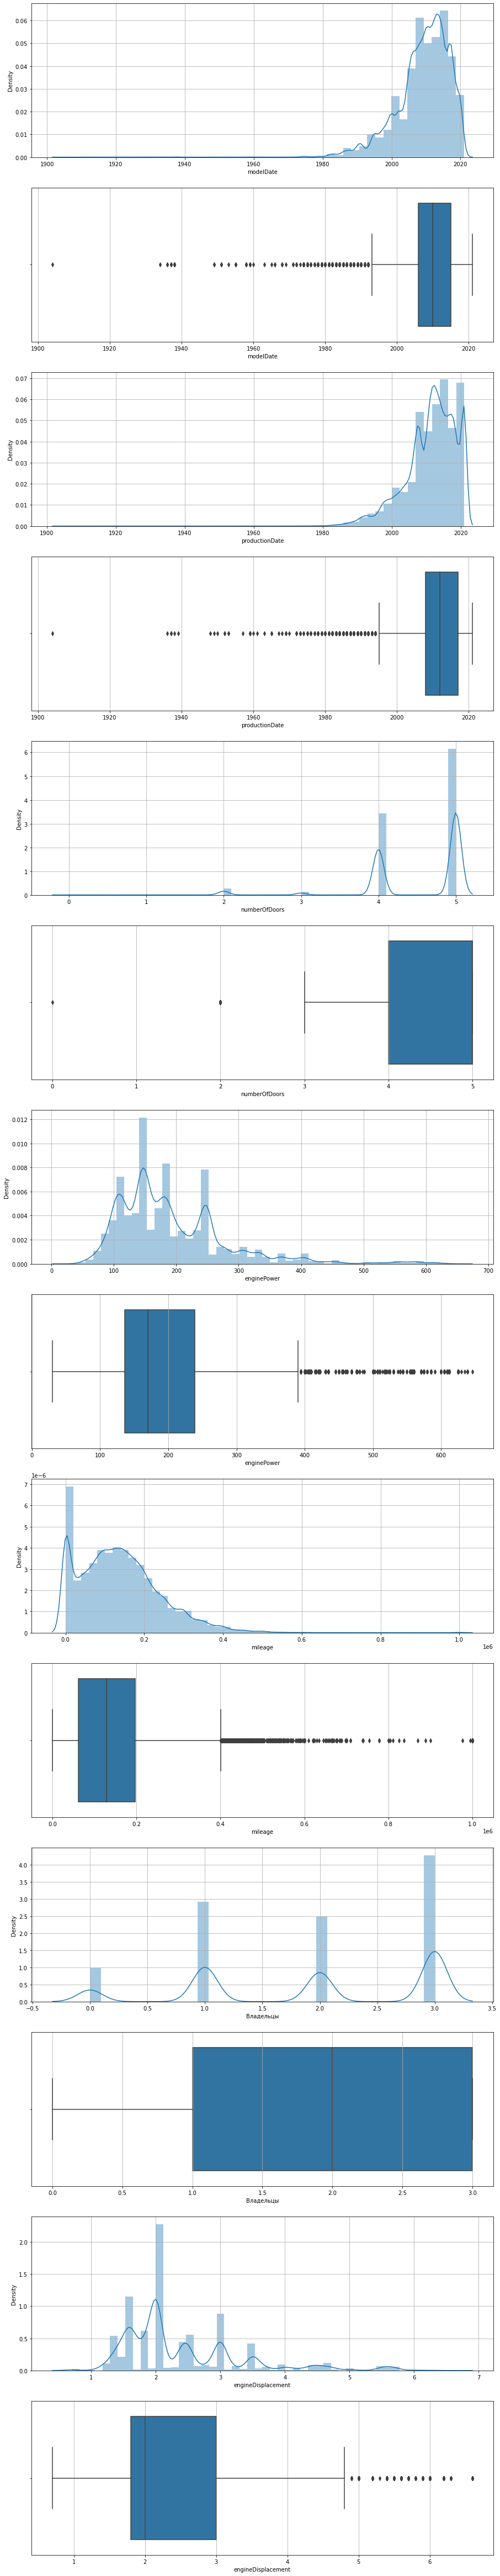

In [167]:
# Смотрим на распределение и наличие выбросов в количественных переменных
fig, axes = plt.subplots(14, 1, figsize=(15, 85))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

i = 0

for col in num_cols:
    sns.distplot(data[col], ax=axes[i]).grid(visible=True)
    i = i + 1
    sns.boxplot(data[col], ax=axes[i]).grid(visible=True, axis='x')
    i = i + 1

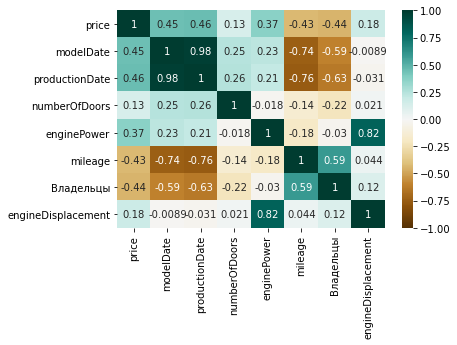

In [168]:
# Построим матрицу корреляции колличественных переменных с целевой
heatmap = sns.heatmap(data[target_col + num_cols].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

**modelDate** почти полностью коррелирует с **productionDate**, оставим только один из них

In [169]:
data = data.drop(columns='modelDate')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71202 entries, 0 to 71201
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bodyType                     71202 non-null  object 
 1   brand                        71202 non-null  object 
 2   color                        71202 non-null  object 
 3   engineDisplacement           71202 non-null  float64
 4   enginePower                  71202 non-null  float64
 5   fuelType                     71202 non-null  object 
 6   mileage                      71202 non-null  float64
 7   model_name                   71202 non-null  object 
 8   numberOfDoors                71202 non-null  int64  
 9   productionDate               71202 non-null  int64  
 10  sell_id                      71202 non-null  int64  
 11  vehicleConfiguration         71202 non-null  object 
 12  vehicleTransmission          71202 non-null  object 
 13  vendor          

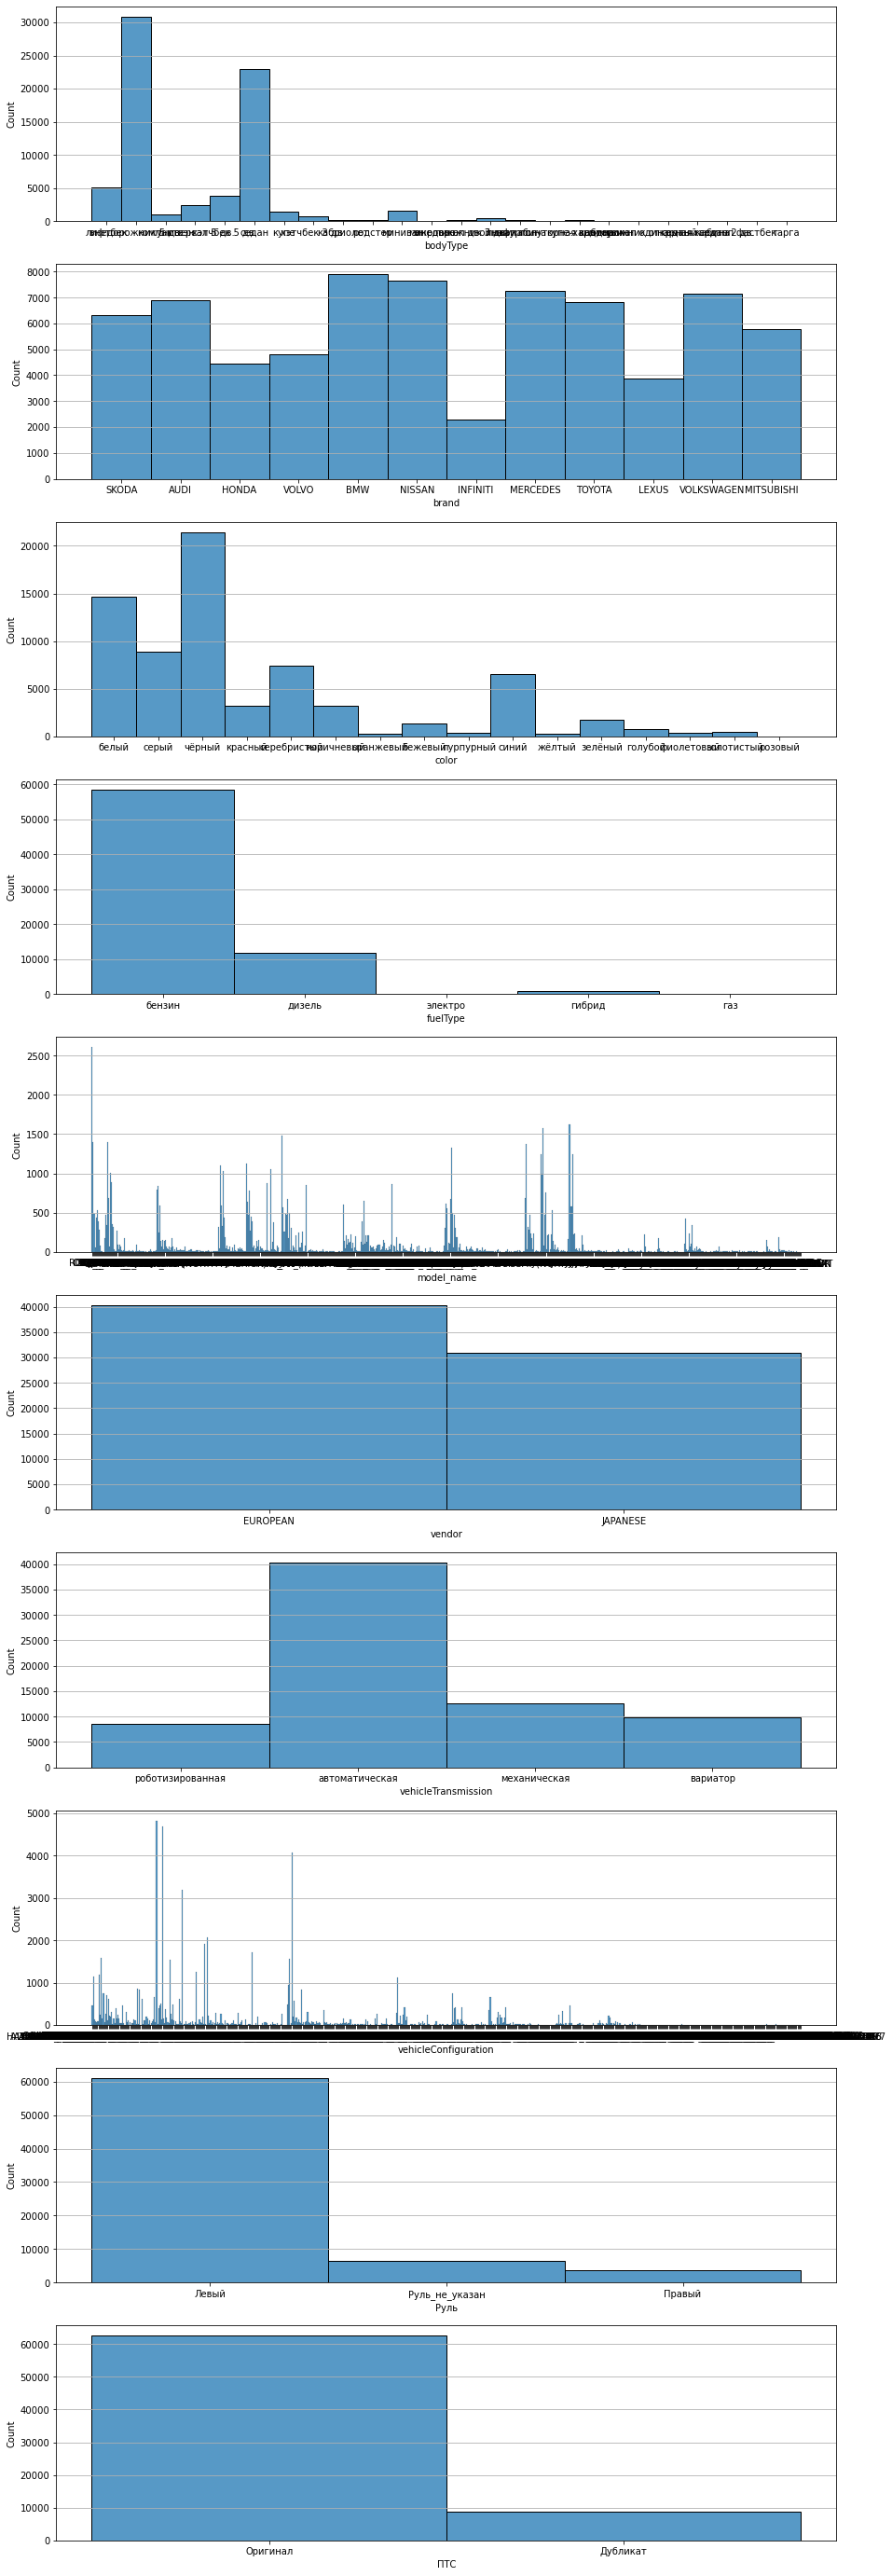

In [170]:
# Смотрим на распределение категориальных показателей
fig, axes = plt.subplots(10, 1, figsize=(15, 50))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

i = 0

for col in (cat_cols + bin_cols):
    sns.histplot(data[col], ax=axes[i]).grid(visible=True, axis='y')
    i += 1

In [171]:
# Смотрим на количество уникальных значений признаков model_name и bodyType
for col in (cat_cols + bin_cols):
    print(col, len(data[col].unique()))

bodyType 24
brand 12
color 16
fuelType 5
model_name 746
vendor 2
vehicleTransmission 4
vehicleConfiguration 695
Руль 3
ПТС 2


<AxesSubplot:xlabel='price', ylabel='Count'>

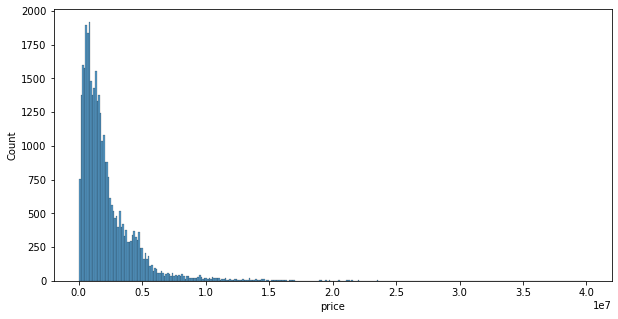

In [172]:
# Смотрим на распределение целефой переменной
fig, axe = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data['Train?'] == 1], x='price')

In [173]:
# Распределение не нормальное, добавим признак логарифмированной цены
data['price_log'] = data.price.apply(lambda x: np.log(x+1))

<AxesSubplot:xlabel='price_log', ylabel='Count'>

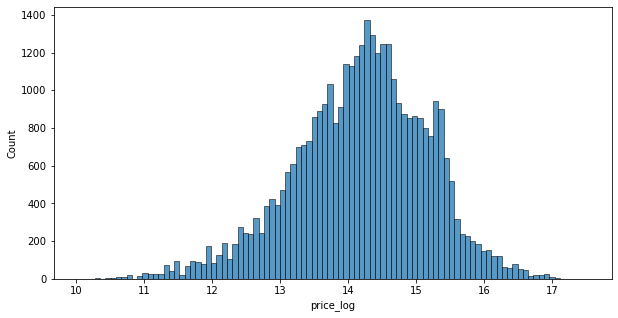

In [174]:
# Смотрим на распределение догорифмированной целевой переменной
fig, axe = plt.subplots(figsize=(10, 5))
sns.histplot(data=data[data['Train?'] == 1], x='price_log')

In [175]:
# Добавляем признак к списку целевых
target_col.append('price_log')

In [176]:
# Логарифмируем смещенные числовые признаки
cols_to_log = ['enginePower', 'mileage', 'engineDisplacement']

for col in cols_to_log:
    data[col] = data[col].apply(lambda x: np.log(x+1))

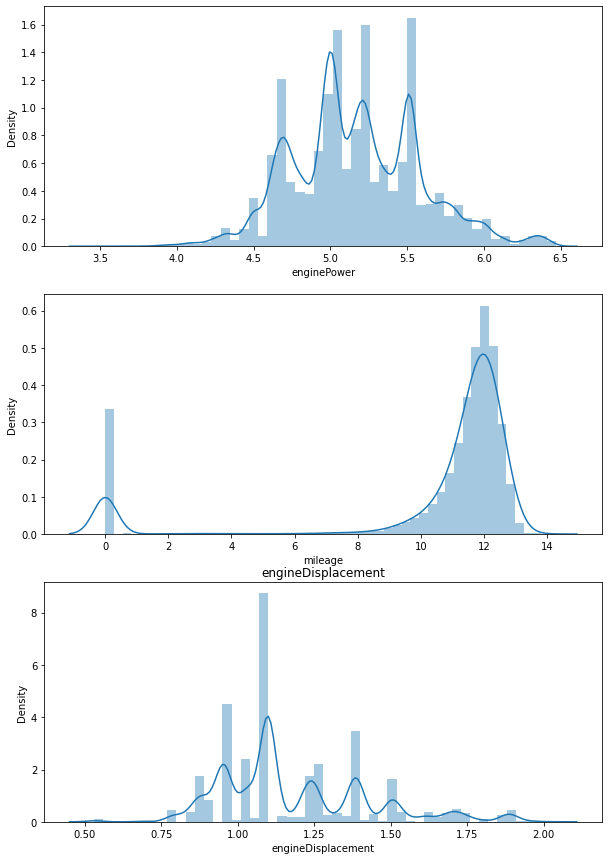

In [177]:
# Смотрим на распределение после логарифмирования
fig, axes = plt.subplots(len(cols_to_log), figsize=(10, 15))
axes = axes.flatten()
i = 0

for col in cols_to_log:
    sns.distplot(data[col], ax=axes[i])
    plt.title(col)
    i += 1

# Преобразование текстовых значений в числовые

In [178]:
# Преобразуем категориальные текстовые признаки в числовые
for column in cat_cols:
    data[column] = LabelEncoder().fit_transform(data[column])

In [179]:
data[cat_cols].sample(10)

,bodyType,brand,color,fuelType,model_name,vendor,vehicleTransmission,vehicleConfiguration,Руль
15396,1,1,6,0,717,0,0,33,2
39239,15,0,15,0,65,0,0,538,0
3175,8,8,1,0,447,0,0,354,2
57142,15,9,1,0,406,1,0,503,1
22476,1,5,15,0,273,0,0,60,0
2742,19,8,4,0,251,0,2,656,0
31628,23,10,11,0,482,0,2,324,0
55254,1,5,15,0,308,0,0,61,0
39366,8,0,15,0,61,0,3,372,0
48728,23,7,13,0,649,1,0,310,0


In [180]:
# Преобразуем признак ПТС в числовой
data['ПТС'] = LabelEncoder().fit_transform(data['ПТС'])

In [181]:
data['ПТС'].sample(10)

28292    1
48250    1
21496    0
42907    1
48137    1
41818    0
18081    1
5943     1
70403    1
9048     1
Name: ПТС, dtype: int32

# Стандартизация числовых переменных

In [182]:
# Применим стандартизацию к оставшимся числовым переменным
cols_to_std = list(set(data.columns) & set(num_cols))

for col in cols_to_std:
    data[col] = StandardScaler().fit_transform(data[cols_to_std])

In [183]:
data[cols_to_std].sample(10)

,enginePower,Владельцы,mileage,engineDisplacement,numberOfDoors,productionDate
48280,-0.449355,-0.449355,-0.449355,-0.449355,-0.449355,-0.449355
16822,0.844945,0.844945,0.844945,0.844945,0.844945,0.844945
54684,0.806131,0.806131,0.806131,0.806131,0.806131,0.806131
4989,1.370342,1.370342,1.370342,1.370342,1.370342,1.370342
58467,1.065534,1.065534,1.065534,1.065534,1.065534,1.065534
16819,1.339191,1.339191,1.339191,1.339191,1.339191,1.339191
21546,1.542035,1.542035,1.542035,1.542035,1.542035,1.542035
21482,1.542035,1.542035,1.542035,1.542035,1.542035,1.542035
60576,0.197168,0.197168,0.197168,0.197168,0.197168,0.197168
16245,1.339191,1.339191,1.339191,1.339191,1.339191,1.339191


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71202 entries, 0 to 71201
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bodyType                     71202 non-null  int32  
 1   brand                        71202 non-null  int32  
 2   color                        71202 non-null  int32  
 3   engineDisplacement           71202 non-null  float64
 4   enginePower                  71202 non-null  float64
 5   fuelType                     71202 non-null  int32  
 6   mileage                      71202 non-null  float64
 7   model_name                   71202 non-null  int32  
 8   numberOfDoors                71202 non-null  float64
 9   productionDate               71202 non-null  float64
 10  sell_id                      71202 non-null  int64  
 11  vehicleConfiguration         71202 non-null  int32  
 12  vehicleTransmission          71202 non-null  int32  
 13  vendor          

# Подготовка итогового датасета к выбору модели

In [185]:
# Отделим обучающую выборку от тестовой и выделим целевую переменную
X = data[data['Train?'] == 1].drop(columns=['Train?', 'price', 'price_log'])
y = data[data['Train?'] == 1].price

In [186]:
# Разбиваем обучающую выборку на обучающую и тестовую для выбора модели
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Выбор модели
В качестве объекта сравнения возьмем модель линейной регрессии с базовыми параметрами.

## LinearRegression

In [187]:
l_model = LinearRegression()
l_model.fit(X_train, y_train)
l_y_pred = l_model.predict(X_test)

print("Точность модели по метрике MAPE:", mape(y_test, l_y_pred))

Точность модели по метрике MAPE: 0.8428479853255585


In [188]:
# С логарифмированием цены
l_model_log = LinearRegression()
l_model_log.fit(X_train, np.log(y_train))
l_y_pred_log = np.exp(l_model_log.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, l_y_pred_log))

Точность модели по метрике MAPE: 0.3673869946433811


## DecisionTreeRegressor

In [189]:
dtr_model = DecisionTreeRegressor(max_depth=4, random_state=RANDOM_SEED)
dtr_model.fit(X_train, y_train)
dtr_y_pred = dtr_model.predict(X_test)

print("Точность модели по метрике MAPE:", mape(y_test, dtr_y_pred))

Точность модели по метрике MAPE: 0.6047549721207164


In [190]:
# С логарифмированием цены
dtr_model_log = DecisionTreeRegressor(max_depth=4, random_state=RANDOM_SEED)
dtr_model_log.fit(X_train, np.log(y_train))
dtr_pred_log = np.exp(dtr_model_log.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, dtr_pred_log))

Точность модели по метрике MAPE: 0.41090500852568695


## RandomForestRegressor

In [191]:
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Точность модели по метрике MAPE:", mape(y_test, rf_pred))

Точность модели по метрике MAPE: 0.1803075655216078


In [192]:
# С логарифмированием цены
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train, np.log(y_train))
rf_pred_log = np.exp(rf.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, rf_pred_log))

Точность модели по метрике MAPE: 0.16067133138858175


Попробуем подобрать оптимальные гиперпараметры для этой модели

In [ ]:
rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

# Задаем сетку гиперпараметров
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(5, 15, num = 6)] + [None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Проведем поиск оптимальных параметров
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_train, y_train)

In [407]:
# Выведем список оптимальных параметров
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None,
 'bootstrap': True}

Опытным путем, уже без использования RandomizedSearchCV, который отрабатывает крайне долго, выяснил количество n_estimators при котором MAPE перестала уменьшаться.

In [215]:
rf_best_params = {'n_estimators': 1000,
                  'min_samples_split': 2,
                  'min_samples_leaf': 1,
                  'max_features': 'log2',
                  'max_depth': None,
                  'bootstrap': True}

In [213]:
# Подставим параметры в модель
rf_best = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1).set_params(**rf_best_params)
rf_best.fit(X_train, y_train)
rf_best_pred = rf_best.predict(X_test)

print("Точность модели по метрике MAPE:", mape(y_test, rf_best_pred))

Точность модели по метрике MAPE: 0.1817294839081876


In [216]:
# С логарифмированием цены
rf_best = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1).set_params(**rf_best_params)
rf_best.fit(X_train, np.log(y_train))
rf_best_pred_log = np.exp(rf_best.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, rf_best_pred_log))

Точность модели по метрике MAPE: 0.16121876454741332


## ExtraTreesRegressor

In [405]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
etr.fit(X_train, y_train)
etr_pred = etr.predict(X_test)

print("Точность модели по метрике MAPE:", mape(y_test, etr_pred))

Точность модели по метрике MAPE: 0.18246258656730857


In [221]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
etr.fit(X_train, np.log(y_train))
etr_pred_log = np.exp(etr.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, etr_pred_log))

Точность модели по метрике MAPE: 0.1672589992685239


In [217]:
# Попробуем подобрать оптимальные гиперпараметры для этой модели
# Задаем сетку гиперпараметров
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(5, 15, num = 6)] + [None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
etr_random.fit(X_train, np.log(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 7, 9, 11, 13, 15,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [218]:
# Выведем список оптимальных параметров
etr_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [230]:
# Опытным путем выяснил оптимальное значение n_estimators
etr_best_params = {'n_estimators': 1200,
                   'min_samples_split': 10,
                   'min_samples_leaf': 1,
                   'max_features': 'auto',
                   'max_depth': None,
                   'bootstrap': False}

In [231]:
# Подставим параметры в модель
etr_best = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1).set_params(**etr_best_params)
etr_best.fit(X_train, np.log(y_train))
etr_best_pred_log = np.exp(etr_best.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, etr_best_pred_log))

Точность модели по метрике MAPE: 0.1575702667588203


## CatBoost

In [249]:
cb = CatBoostRegressor(random_seed = RANDOM_SEED, 
                       iterations = 5000,
                       eval_metric='MAPE',
                       silent=True)
cb.fit(X_train, np.log(y_train))
cb_pred = np.exp(cb.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, cb_pred))

Точность модели по метрике MAPE: 0.17184574851913959


## XGBRegressor

In [260]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                           colsample_bytree=0.5,
                           learning_rate=0.08, 
                           max_depth=8, 
                           alpha=1,
                           n_estimators=1000, 
                           random_state=RANDOM_SEED, 
                           n_jobs=-1)
xgb_reg.fit(X_train, np.log(y_train))
xgb_reg_pred = np.exp(xgb_reg.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, xgb_reg_pred))

Точность модели по метрике MAPE: 0.1543516780073612


## BaggingRegressor
Лучшие модели у нас получились **RandomForestRegressor** с базовыми параметрами и **ExtraTreesRegressor**. Будем объединять их.

In [243]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
bag_rfr = BaggingRegressor(rfr, n_jobs=-1, random_state=RANDOM_SEED)
bag_rfr.fit(X_train, np.log(y_train))
bag_rfr_pred = np.exp(bag_rfr.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, bag_rfr_pred))

Точность модели по метрике MAPE: 0.16074493315711053


In [237]:
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)
bag_etr = BaggingRegressor(etr, n_jobs=-1, random_state=RANDOM_SEED)
bag_etr.fit(X_train, np.log(y_train))
bag_etr_pred = np.exp(bag_etr.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, bag_etr_pred))

Точность модели по метрике MAPE: 0.16268518007850566


In [264]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                           colsample_bytree=0.5,
                           learning_rate=0.08, 
                           max_depth=8, 
                           alpha=1,
                           n_estimators=1000, 
                           random_state=RANDOM_SEED, 
                           n_jobs=-1)
bag_xgb = BaggingRegressor(xgb_reg, n_jobs=-1, random_state=RANDOM_SEED)
bag_xgb.fit(X_train, np.log(y_train))
bag_xgb_pred = np.exp(bag_xgb.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, bag_xgb_pred))

Точность модели по метрике MAPE: 0.15572811684368762


## StackingRegressor

### ExtraTreesRegressor, RandomForestRegressor, final - LinearRegression

In [262]:
# Базовые модели для генерации параметров
estimators = [('etr',ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1)), 
              ('rfr', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))]

# Модель стекинга, результирующая - линейная регрессия
st_1 = StackingRegressor(estimators=estimators, 
                         final_estimator=LinearRegression(), 
                         n_jobs=-1)
st_1.fit(X_train, np.log(y_train))
st_1_pred = np.exp(st_1.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, st_1_pred))

Точность модели по метрике MAPE: 0.1609230623833227


### XGBRegressor, ExtraTreesRegressor, final - LinearRegression

In [265]:
# Базовые модели для генерации параметров
estimators = [('etr',ExtraTreesRegressor(random_state=RANDOM_SEED, 
                                         n_jobs=-1)), 
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror', 
                                           colsample_bytree=0.5,
                                           learning_rate=0.08, max_depth=8, 
                                           alpha=1, n_estimators=1000, 
                                           random_state=RANDOM_SEED, 
                                           n_jobs=-1))]

# Модель стекинга, результирующая - линейная регрессия
st_2 = StackingRegressor(estimators=estimators, 
                         final_estimator=LinearRegression(), 
                         n_jobs=-1)
st_2.fit(X_train, np.log(y_train))
st_2_pred = np.exp(st_2.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, st_2_pred))

Точность модели по метрике MAPE: 0.15332111257556766


### XGBRegressor, RandomForestRegressor, final - LinearRegression

In [268]:
# Базовые модели для генерации параметров
estimators = [('rfr', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)), 
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror', 
                                           colsample_bytree=0.5,
                                           learning_rate=0.08, max_depth=8, 
                                           alpha=1, n_estimators=1000, 
                                           random_state=RANDOM_SEED, 
                                           n_jobs=-1))]

# Модель стекинга, результирующая - линейная регрессия
st_4 = StackingRegressor(estimators=estimators, 
                         final_estimator=LinearRegression(), 
                         n_jobs=-1)
st_4.fit(X_train, np.log(y_train))
st_4_pred = np.exp(st_4.predict(X_test))

print("Точность модели по метрике MAPE:", mape(y_test, st_4_pred))

Точность модели по метрике MAPE: 0.1527522536022689
